## Disclaimer

The results in this notebook will naturally change as new tournaments are added.

In [1]:
import os
import sys
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.linear_model as lm
import statsmodels.formula.api as smf
import statsmodels.api as sm
import itertools

# import dmsrc
sys.path.insert(0, "../")
import dmsrc
sys.path.insert(0, "../scrape/")
from combine import _combine_multicols

## Load data and initial manipulations

In [2]:
all_speakers = pd.read_csv("../data/combined/all_speakers.csv")

In [3]:
# load all rounds before 2020
all_rounds = pd.read_csv("../data/combined/round_data.csv")
all_rounds = all_rounds.loc[
    all_rounds['date'].apply(lambda x: x.split("/")[0]).astype(int) > 2019
]
all_rounds['room_id'] = np.arange(len(all_rounds))

In [4]:
# separate inrounds and outrounds
sides = ['OG', 'OO', 'CG', 'CO']
speaks_cols = []
for side in sides:
    speaks_cols.extend([f"{side}_speaks{sid}" for sid in ['0', '1']])
    
flags = all_rounds[speaks_cols].notnull().sum(axis=1) == 0 # no speaks => outround
outrounds = all_rounds.loc[flags].copy()
rdf = all_rounds.loc[~flags].copy()

In [5]:
# mark last round
last_round = rdf.groupby(['tourn_id'])['round_number'].max().to_dict()
rdf['last_round'] = rdf.apply(
    lambda row: row['round_number'] == last_round[row['tourn_id']], axis='columns'
)

## Reduce data to get ready for regression

In [6]:
def elapsed(t0):
    return np.around(time.time() - t0, 3)

In [7]:
def _fetch_features(side, sid):
    _features = [
        f"{side}_speaker_id{sid}", # speaker ID
        #f"{side}_speaker_id{1-sid}", # partner ID,
        "tourn_id",
        "round_number",
    ]
    fdict = {_features[0]:"speaker_id"}#, _features[1]:"partner_id"}
    return _features, fdict

In [8]:
def create_X_y(rdf, _fetch_features, speaks_only=True):
    # create Xs, ys
    ys = []
    Xs = []
    for side in sides:
        for sid in [0, 1]:
            ysub = rdf[f"{side}_speaks{sid}"]
            ys.append(ysub)
            _features, fdict = _fetch_features(side, sid)
            Xsub = rdf[_features].copy()
            if 'tourn_id' in Xsub.columns and 'round_number' in Xsub.columns:
                Xsub['tourn_round'] = Xsub['tourn_id'].astype(str) + "_" + Xsub['round_number'].astype(str)
                Xsub = Xsub.drop(['round_number'], axis='columns')
            Xsub = Xsub.rename(columns=fdict)
            Xsub['side'] = side
            Xsub['speaker_pos'] = sid
            # for indexing
            Xsub['room_id'] = rdf['room_id']
            Xsub['date'] = rdf['date']
            Xsub['speaks'] = ysub
            Xs.append(Xsub)
    # return
    X = pd.concat(Xs, axis='index')
    for c in ['speaker_id', 'partner_id']:
        if c in X.columns:
            X[c] = X[c].astype(str)
    Xv = pd.get_dummies(
        X.drop(["room_id", "date", "speaks"], axis='columns')
    )
    y = pd.concat(ys, axis='index')
    y[~y.notnull()] = y.mean() # impute with mean
    return Xv, X, y    

## Evaluation metrics

In [9]:
def make_oos_predictions(
    beta, Xtest, intercept=0
):
    """
    Creates out of sample predictions of speaks
    
    Parameters
    ----------
    Xtest : pd.DataFrame
    beta : pd.Series
    """
    intcols = list(
        set(list(Xtest.columns)).intersection(set(list(beta.index)))
    )
    return Xtest[intcols].values @ beta[intcols].values + intercept

In [10]:
def report_result(
    losses, metric
):
    """ Prints confidence interval """
    print(f"For metric={metric}, CI for loss is:")
    loss = losses.mean()
    se = np.sqrt(losses.std() / len(losses))
    print(
        np.around(loss - 2*se, 5), 
        np.around(loss, 5), 
        np.around(loss + 2*se, 5)
    )
    

def ranking_accuracy(
    rdf_test,
    Xtest_df, 
    ypreds,
    metric='outrounds',
    verbose=True,
):
    # pivot to room-by-room format
    Xtest_df['preds'] = ypreds
    rpreds = Xtest_df[['preds', 'side', 'room_id', 'speaker_pos']].pivot(
        index='room_id', columns=['side', 'speaker_pos']
    )['preds']
    # Add speaker scores together to determine ranks
    rpreds_comb = pd.DataFrame(index=rpreds.index)
    for side in sides:
        rpreds_comb[side+"_rank"] = rpreds[side][0] + rpreds[side][1]
    # predicted ranks
    rank_preds = rpreds_comb.T.rank().T - 1
    # now compute accuracy
    truth = rdf_test.set_index("room_id")[[f"{s}_rank" for s in sides]]
    if metric == 'outrounds':
        # if finals, only 1 team advances
        finals_flags = ((truth != 0).sum(axis=1) == 1).astype(int)
        advance_preds = rank_preds.copy()
        for c in advance_preds.columns:
            advance_preds[c] = advance_preds[c] >= (finals_flags + 2)
        advance_preds = advance_preds.astype(int)

        truth = truth >= 1
        # 0-1 loss
        losses = np.mean(advance_preds != truth, axis=1)
    elif metric == 'inrounds_l2':
        losses = np.mean((rank_preds - truth)**2, axis=1)
    elif metric == 'comparisons':
        losses = np.zeros(len(rank_preds))
        for s0, s1 in itertools.combinations(sides, 2):
            c0 = f'{s0}_rank'; c1 = f'{s1}_rank'
            losses += np.logical_xor(
                (rank_preds[c0] < rank_preds[c1]).values,
                (truth[c0] < truth[c1]).values
            ).astype(int)
    
    loss = losses.mean()
    if verbose:
        report_result(losses, metric)
    return pd.Series(losses, rank_preds.index, name='loss')

In [11]:
def compute_outrounds_accuracy(
    outrounds, _fetch_features, beta
):
    # predict on outrounds
    Xout, Xout_df, _ = create_X_y(outrounds, _fetch_features)
    # look at intersection of columns
    # everything else is 0 and doesn't contribute to preds anyway
    or_preds = make_oos_predictions(beta, Xout)
    ranking_accuracy(
        outrounds,
        Xout_df,
        or_preds,
        metric='outrounds',
        verbose=True
    )

In [12]:
def eval_feature_set(
    rdf, outrounds, _fetch_features, 
):
    t0 = time.time()
    # eval on last round of each tournament
    print(f"Training on all rounds except last inround at {elapsed(t0)}.")
    Xtrain, _, ytrain = create_X_y(
        rdf.loc[~rdf['last_round']], _fetch_features
    )
    ridge = lm.Ridge()
    ridge.fit(Xtrain.values, ytrain.values)
    beta = pd.Series(ridge.coef_, index=Xtrain.columns)
    # report metrics
    lrounds = rdf.loc[rdf['last_round']]
    Xtest, Xtestdf, ytest = create_X_y(
        lrounds, _fetch_features, 
    )
    ypreds = make_oos_predictions(beta, Xtest, ridge.intercept_)
    losses = (ypreds - ytest)**2
    report_result(losses, "speaks_l2")
    for metric in ['comparisons', 'inrounds_l2']:
        losses = ranking_accuracy(
            rdf_test=rdf.loc[rdf['last_round']],
            Xtest_df=Xtestdf, 
            ypreds=ypreds,
            metric=metric
        )
    # Train full model
    print(f"Training on all inrounds at {elapsed(t0)}.")
    X, Xdf, y = create_X_y(rdf, _fetch_features)
    ridge = lm.Ridge()
    ridge.fit(X.values, y.values)
    beta = pd.Series(ridge.coef_, index=X.columns)
    print(f"Finished training at {elapsed(t0)}.")
    compute_outrounds_accuracy(outrounds, _fetch_features, beta)
    return ridge, beta, X, Xdf, y


## Fit model

In [13]:
# This should be pretty quick
# because we're not even using cross-validation
ridge, beta, X, Xdf, y = eval_feature_set(
    rdf, outrounds, _fetch_features
)

Training on all rounds except last inround at 0.0.
For metric=speaks_l2, CI for loss is:
5.88698 5.97599 6.06501
For metric=comparisons, CI for loss is:
1.94555 2.0273 2.10904
For metric=inrounds_l2, CI for loss is:
1.46669 1.54591 1.62512
Training on all inrounds at 6.464.
Finished training at 13.793.
For metric=outrounds, CI for loss is:
0.25815 0.31338 0.36861


## Inspect results

In [14]:
# process linear coefficients (beta) 
beta.name = 'skill'
skills = pd.DataFrame(
    beta[[c for c in beta.index if 'speaker_id' in c]]
).reset_index().rename(columns={"index":"id"})
skills['id'] = skills['id'].apply(
    lambda x: x.split("_")[-1]
).astype(int)
# merge estimated skills with speaker names
skills = pd.merge(
    skills,
    all_speakers,
)

In [15]:
# Top 30 estimated skill levels 
# this is unreliable (there are no standard errors even)
skills.sort_values("skill", ascending=False).head(n=30)

,id,skill,name
2898,4014,7.643607,tin puljic
1387,2436,7.004348,lovro sprem
1730,2792,6.932463,milos marjanovic
704,1718,6.565627,ignacio villareal
1570,2627,6.438349,matt caito
2904,4020,6.366610,tobi leung
550,1559,6.256905,hadar goldberg
2850,3964,6.246101,tejas subramaniam
40,1038,6.244723,david demitri africa
35,1033,6.004960,david africa


We could also plot where people lie on the distribution of skill levels (with the knowledge that this is an academic exercise because this model is very misspecified; for example, skill levels clearly change over time). 

For fun I'll use Greg Weaving as my guinea pig.

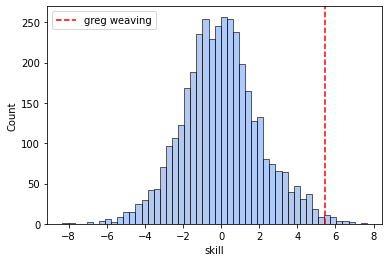

In [19]:
# Distribution of estimated skill levels
fig, ax = plt.subplots()
sns.histplot(skills['skill'], ax=ax, color='cornflowerblue', alpha=0.5)
# Add a few people in
for name, color in zip(
    ['greg weaving'],
    ['red'],
):
    yint = skills.loc[
        skills['name'].str.contains(name)
    ]['skill'].item()
    # Add tejas
    ax.axvline(yint, color=color, label=name, linestyle='dashed')
# Show plot
plt.legend()
plt.show()